In [ ]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/metadata.csv", delimiter=";")
metadata.head()

,Building identifier,Store surface (mq)
0,building_1,367
1,building_2,439
2,building_3,589
3,building_4,515
4,building_5,376


In [ ]:
holidays = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/holidays.csv", delimiter=";")
holidays.head()

,Date and time,Holiday
0,14/11/2021 00:00:00,1
1,14/11/2021 00:15:00,1
2,14/11/2021 00:30:00,1
3,14/11/2021 00:45:00,1
4,14/11/2021 01:00:00,1


In [ ]:
file_path = f"/content/drive/MyDrive/Colab Notebooks/Data/building_1_clean.csv"
df = pd.read_csv(file_path, delimiter=";")
df

,Internal temperature area 1 (Celsius degree),Internal temperature area 2 (Celsius degree),External temperature (Celsius degree),HVAC power (kW),Date,Time
0,22.000,22.5,11.20,3.231,14/11/2021,00:00:00
1,22.250,22.5,11.20,3.929,14/11/2021,00:15:00
2,21.500,22.5,11.21,2.988,14/11/2021,00:30:00
3,21.500,22.5,11.20,3.238,14/11/2021,00:45:00
4,21.500,22.5,11.37,3.335,14/11/2021,01:00:00
...,...,...,...,...,...,...
32806,21.800,22.0,10.62,3.010,13/11/2022,22:45:00
32807,21.500,21.6,10.62,3.308,13/11/2022,23:00:00
32808,21.000,21.0,10.51,2.304,13/11/2022,23:15:00
32809,19.357,20.0,10.55,4.991,13/11/2022,23:30:00


Training sequences (X_train): 23311, Testing sequences (X_test): 1292
Epoch [1/10], Train Loss: 125.1613, Val Loss: 10.8428
Epoch [2/10], Train Loss: 5.7864, Val Loss: 3.4028
Epoch [3/10], Train Loss: 2.7491, Val Loss: 2.2078
Epoch [4/10], Train Loss: 2.0923, Val Loss: 1.9669
Epoch [5/10], Train Loss: 1.9233, Val Loss: 1.9463
Epoch [6/10], Train Loss: 1.8422, Val Loss: 1.8569
Epoch [7/10], Train Loss: 1.7812, Val Loss: 1.8451
Epoch [8/10], Train Loss: 1.7413, Val Loss: 1.7361
Epoch [9/10], Train Loss: 1.6914, Val Loss: 1.6974
Epoch [10/10], Train Loss: 1.6741, Val Loss: 1.7192


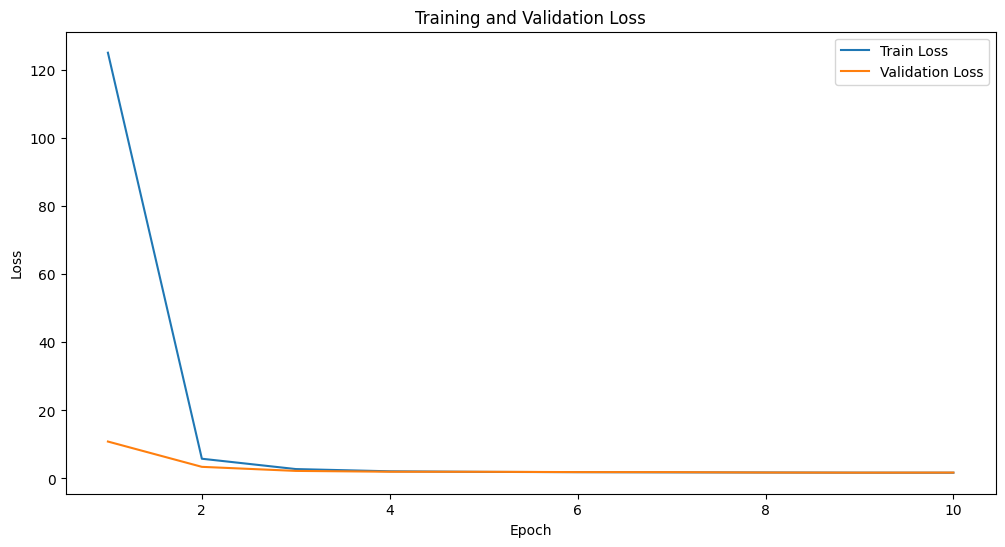

Final Validation Loss: 1.7192
R^2 Score on Test Set: 0.0162


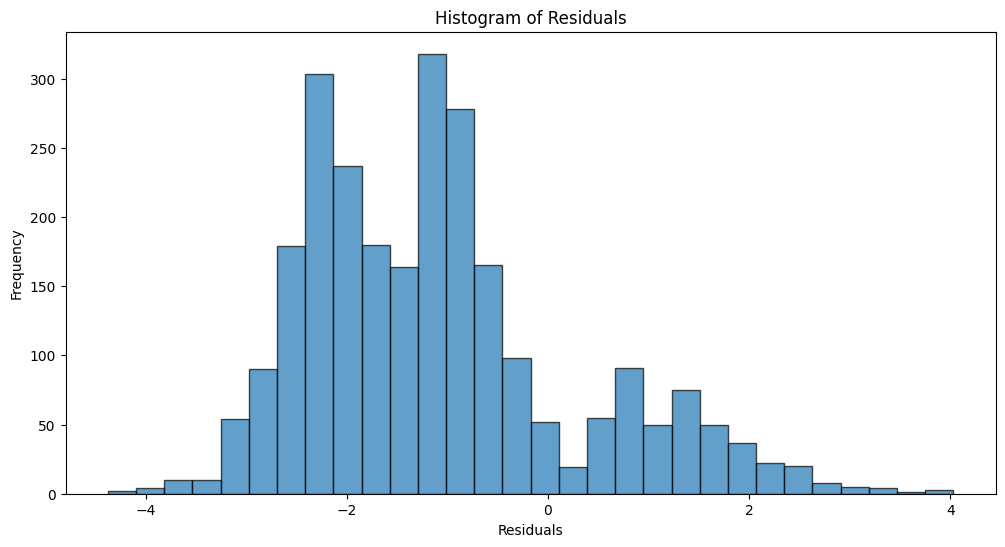

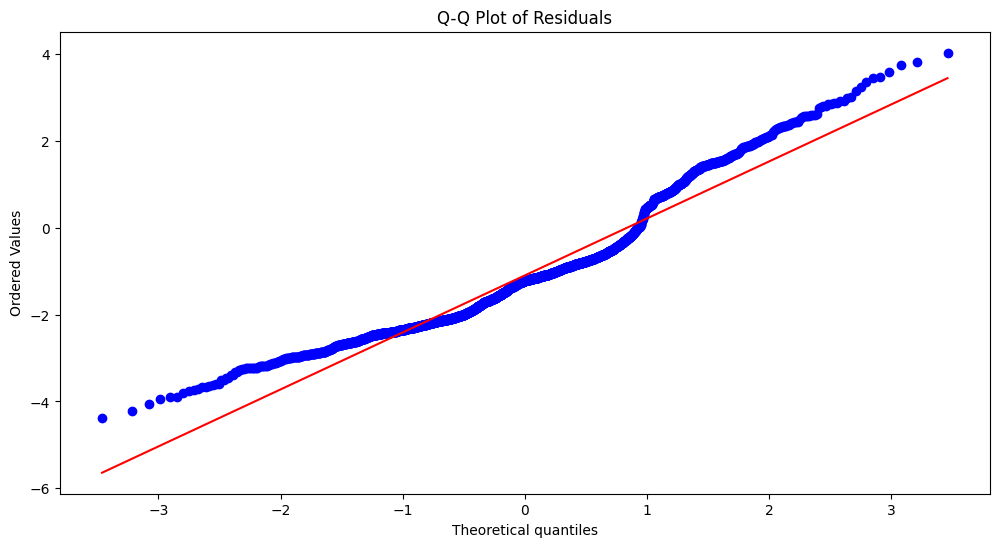

Shapiro-Wilk Test Statistic: 0.9414
Shapiro-Wilk Test p-value: 0.0000
Kolmogorov-Smirnov Test Statistic: 0.1035
Kolmogorov-Smirnov Test p-value: 0.0000


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

# Step 1: Load the Data
file_path = "/content/drive/MyDrive/Colab Notebooks/Data/building_1_clean.csv"
df = pd.read_csv(file_path, delimiter=";")

# Load and preprocess holidays data
holidays = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/holidays.csv", delimiter=";")
holidays['Date and time'] = pd.to_datetime(holidays['Date and time'], format='%d/%m/%Y %H:%M:%S')
holidays.set_index('Date and time', inplace=True)
holidays = holidays[['Holiday']]

# Combine Date and Time into a single DateTime column and set it as index
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('DateTime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Fill missing values (if any) using forward fill
df.ffill(inplace=True)

# Merge with holidays data
df = df.join(holidays, how='left').fillna({'Holiday': 0})

# Step 2: Organize Data by Day
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 2:])  # External temperature + Holiday indicator
        y.append(data[i+sequence_length, :2])    # Internal temperatures
    return np.array(X), np.array(y)

# Group by day
daily_groups = df.groupby(df.index.date)
dates = list(daily_groups.groups.keys())

# Split dates into training and testing
split_index = int(len(dates) * 0.95)
train_dates = dates[:split_index]
test_dates = dates[split_index:]

# Function to get sequences for given dates
def get_sequences_for_dates(dates):
    X_list, y_list = [], []
    for date in dates:
        group = df.loc[df.index.date == date]
        X_day, y_day = create_sequences(group.values, sequence_length)
        X_list.append(X_day)
        y_list.append(y_day)
    return np.concatenate(X_list), np.concatenate(y_list)

sequence_length = 24  # Number of time steps in each sequence

# Get sequences for training and testing sets
X_train, y_train = get_sequences_for_dates(train_dates)
X_test, y_test = get_sequences_for_dates(test_dates)

print(f"Training sequences (X_train): {X_train.shape[0]}, Testing sequences (X_test): {X_test.shape[0]}")

# Ensure that there is data for training and testing
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Training or testing data is empty. Check your split and data preparation.")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Combine training and testing data into a single dataset
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the split ratio
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Step 3: Define the Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

input_size = 3  # External temperature + Holiday indicator
hidden_size = 50
output_size = 2  # Internal temperatures
num_layers = 1

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Step 4: Train the Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Step 5: Evaluate the Model
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(y_batch.numpy())

    test_predictions = np.concatenate(test_predictions)
    test_targets = np.concatenate(test_targets)

    # Calculate residuals
    residuals = test_targets - test_predictions

    # Calculate R^2
    r2 = r2_score(test_targets, test_predictions)

# Calculate final validation loss
final_val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        final_val_loss += loss.item() * X_batch.size(0)
final_val_loss /= len(val_loader.dataset)

print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'R^2 Score on Test Set: {r2:.4f}')

# Step 6: Analyze the Residuals

# Flatten the residuals for analysis
residuals = residuals.flatten()

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}')
print(f'Shapiro-Wilk Test p-value: {shapiro_test.pvalue:.4f}')

# Kolmogorov-Smirnov test for normality
ks_test = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f'Kolmogorov-Smirnov Test Statistic: {ks_test.statistic:.4f}')
print(f'Kolmogorov-Smirnov Test p-value: {ks_test.pvalue:.4f}')


## All the datasets

In [ ]:
import pandas as pd

# Lista per salvare i dataframe temporanei
temp_dfs = []

# Loop per caricare i file CSV
for i in range(1, 5):  # Da 1 a 4
    file_path = f"/content/drive/MyDrive/Colab Notebooks/Data/building_{i}_clean.csv"
    try:
        df = pd.read_csv(file_path, delimiter=";")
        temp_dfs.append(df)
        print(f"Caricato file {file_path}")
    except FileNotFoundError:
        print(f"File non trovato: {file_path}")

combined_df

Caricato file /content/drive/MyDrive/Colab Notebooks/Data/building_1_clean.csv
Caricato file /content/drive/MyDrive/Colab Notebooks/Data/building_2_clean.csv
Caricato file /content/drive/MyDrive/Colab Notebooks/Data/building_3_clean.csv
Caricato file /content/drive/MyDrive/Colab Notebooks/Data/building_4_clean.csv


,Internal temperature area 1 (Celsius degree),Internal temperature area 2 (Celsius degree),External temperature (Celsius degree),HVAC power (kW),Date,Time
0,22.00,22.50,11.20,3.231,14/11/2021,00:00:00
1,22.25,22.50,11.20,3.929,14/11/2021,00:15:00
2,21.50,22.50,11.21,2.988,14/11/2021,00:30:00
3,21.50,22.50,11.20,3.238,14/11/2021,00:45:00
4,21.50,22.50,11.37,3.335,14/11/2021,01:00:00
...,...,...,...,...,...,...
95206,19.70,20.65,13.61,0.014,13/11/2022,22:45:00
95207,19.70,20.65,13.61,0.009,13/11/2022,23:00:00
95208,19.70,20.60,13.56,0.000,13/11/2022,23:15:00
95209,19.70,20.65,13.60,0.004,13/11/2022,23:30:00


In [ ]:
import pandas as pd

# Caricamento dei dati di metadata
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/metadata.csv", delimiter=";")
print(metadata.head())  # Mostra le prime righe per ispezionare i dati

# Ispeziona i valori unici nella colonna 'Building identifier'
print(metadata['Building identifier'].unique())

# Se ci sono valori non numerici, sarà necessario pulire i dati
# Esempio di pulizia dei dati: rimuovere qualsiasi valore non numerico
metadata['Building identifier'] = metadata['Building identifier'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
metadata = metadata[metadata['Building identifier'] != '']  # Rimuovi righe con valori vuoti

# Converti 'Building identifier' in int64
metadata['Building identifier'] = metadata['Building identifier'].astype(int)

# Verifica che la conversione sia andata a buon fine
print(metadata.head())

# Assicurati che il tipo di dato per BuildingID sia int64 in entrambi i DataFrame
df['BuildingID'] = df['BuildingID'].astype(int)

# Rinominare la colonna nel DataFrame principale per fare la fusione
df.rename(columns={'BuildingID': 'Building identifier'}, inplace=True)

# Continua con la fusione dei dati come prima
df = df.merge(metadata, on='Building identifier', how='left')
df.drop('Building identifier', axis=1, inplace=True)  # Rimuovere Building identifier dopo la fusione


  Building identifier  Store surface (mq)
0          building_1                 367
1          building_2                 439
2          building_3                 589
3          building_4                 515
4          building_5                 376
['building_1' 'building_2' 'building_3' 'building_4' 'building_5'
 'building_6']
   Building identifier  Store surface (mq)
0                    1                 367
1                    2                 439
2                    3                 589
3                    4                 515
4                    5                 376


In [ ]:
# Caricamento e preprocessing dei dati di metadata
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/metadata.csv", delimiter=";")

# Controlla i nomi delle colonne
print("Nomi delle colonne nel DataFrame metadata:")
print(metadata.columns)

# Rinomina la colonna 'Building identifier' in 'BuildingID'
metadata.rename(columns={'Building identifier': 'BuildingID'}, inplace=True)

# Assicurati che 'BuildingID' in metadata sia di tipo int
metadata['BuildingID'] = metadata['BuildingID'].apply(lambda x: ''.join(filter(str.isdigit, str(x))))
metadata = metadata[metadata['BuildingID'] != '']  # Rimuovi righe con valori vuoti
metadata['BuildingID'] = metadata['BuildingID'].astype(int)

# Assicurati che il tipo di dato per BuildingID sia int64 nel DataFrame principale
df['BuildingID'] = df['BuildingID'].astype(int)

# Aggiungi la superficie al DataFrame principale usando l'area come chiave per la fusione
df = df.merge(metadata, on='BuildingID', how='left')
df.drop('BuildingID', axis=1, inplace=True)  # Rimuovi BuildingID dopo la fusione


Nomi delle colonne nel DataFrame metadata:
Index(['Building identifier', 'Store surface (mq)'], dtype='object')


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load metadata
metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/metadata.csv", delimiter=";")
metadata.set_index('Building identifier', inplace=True)
metadata = metadata[['Store surface (mq)']]

# File paths for the datasets
file_paths = [
    "/content/drive/MyDrive/Colab Notebooks/Data/building_1_clean.csv",
    "/content/drive/MyDrive/Colab Notebooks/Data/building_2_clean.csv",
    "/content/drive/MyDrive/Colab Notebooks/Data/building_3_clean.csv",
    "/content/drive/MyDrive/Colab Notebooks/Data/building_4_clean.csv",
]

# Initialize an empty list to store DataFrames
dfs = []

# Process each dataset
for i, file_path in enumerate(file_paths):
    # Load the dataset
    df = pd.read_csv(file_path, delimiter=";")

    # Extract building identifier
    building_id = file_path.split('/')[-1].split('_')[1]

    # Add store surface to the dataset
    df['Building identifier'] = building_id
    df = df.join(metadata, on='Building identifier', how='left')

    # Combine Date and Time into a single DateTime column and set it as index
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
    df.set_index('DateTime', inplace=True)
    df.drop(['Date', 'Time', 'Building identifier'], axis=1, inplace=True)

    # Fill missing values (if any) using forward fill
    df.ffill(inplace=True)

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=False)

# Load and preprocess holidays data
holidays = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/holidays.csv", delimiter=";")
holidays['Date and time'] = pd.to_datetime(holidays['Date and time'], format='%d/%m/%Y %H:%M:%S')
holidays.set_index('Date and time', inplace=True)
holidays = holidays[['Holiday']]

# Merge with holidays data
df = df.join(holidays, how='left').fillna({'Holiday': 0})

# Ensure the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    raise TypeError("L'indice del DataFrame non è un DatetimeIndex.")

# Step 2: Organize Data by Day
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, 2:])  # External temperature + Holiday indicator + Store surface
        y.append(data[i+sequence_length, :2])    # Internal temperatures
    return np.array(X), np.array(y)

# Group by day
daily_groups = df.groupby(df.index.date)
dates = list(daily_groups.groups.keys())

# Split dates into training and testing
split_index = int(len(dates) * 0.95)
train_dates = dates[:split_index]
test_dates = dates[split_index:]

# Function to get sequences for given dates
def get_sequences_for_dates(dates):
    X_list, y_list = [], []
    for date in dates:
        group = df.loc[df.index.date == date]
        X_day, y_day = create_sequences(group.values, sequence_length)
        X_list.append(X_day)
        y_list.append(y_day)
    return np.concatenate(X_list), np.concatenate(y_list)

sequence_length = 24  # Number of time steps in each sequence

# Get sequences for training and testing sets
X_train, y_train = get_sequences_for_dates(train_dates)
X_test, y_test = get_sequences_for_dates(test_dates)

print(f"Training sequences (X_train): {X_train.shape[0]}, Testing sequences (X_test): {X_test.shape[0]}")

# Ensure that there is data for training and testing
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Training or testing data is empty. Check your split and data preparation.")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Combine training and testing data into a single dataset
dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define the split ratio
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

# Step 3: Define the Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Input size is updated to include store surface (m2)
input_size = 4  # External temperature + Holiday indicator + Store surface (m2)
hidden_size = 50
output_size = 2  # Internal temperatures
num_layers = 1

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Step 4: Train the Model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validate the model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Step 5: Evaluate the Model
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        test_predictions.append(outputs.cpu().numpy())
        test_targets.append(y_batch.numpy())

    test_predictions = np.concatenate(test_predictions)
    test_targets = np.concatenate(test_targets)

    # Calculate residuals
    residuals = test_targets - test_predictions

    # Calculate R^2
    r2 = r2_score(test_targets, test_predictions)

# Calculate final validation loss
final_val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), y_batch.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        final_val_loss += loss.item() * X_batch.size(0)
final_val_loss /= len(val_loader.dataset)

print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'R^2 Score on Test Set: {r2:.4f}')

# Step 6: Analyze the Residuals

# Flatten the residuals for analysis
residuals = residuals.flatten()


Training sequences (X_train): 81343, Testing sequences (X_test): 5324
Epoch [1/10], Train Loss: nan, Val Loss: nan


KeyboardInterrupt: 